In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches




In [14]:
df = pd.read_excel('NutriScore_Dynamic_Dataset.xlsx', sheet_name='Sheet1')
df.head()

,Nom_Produit,Marque,Categorie,Energie_kJ,Sucres_g,Graisses_Sat_g,Sel_g,Proteines_g,Fibres_g,Fruits_Legumes_Pct,NutriScore_Score,NutriScore_Lettre,Points_N,Points_P,GreenScore_Lettre,GreenScore_Score
0,Concentré de tomates Aicha,Aicha,vegetables,132.0,2.43,0.0,0.270,1.24,0.811,0.0,1,B,1,0,C,59
1,Aicha Tomato Paste,Aicha,vegetables,496.0,9.00,0.0,0.500,4.60,3.000,0.0,3,C,4,1,C,46
2,Raw kimchi,Vadasz,vegetables,63.0,0.00,0.1,2.065,1.10,1.800,0.0,10,C,10,0,A,88
3,Beurre de cacahuètes,Maribel,vegetables,2860.0,3.90,12.0,0.030,30.40,9.200,0.0,14,D,19,5,D,34
4,Carottes rapees citron dnp 320g,Bonduelle,vegetables,301.0,4.50,0.3,0.710,1.00,3.000,86.0,-1,A,4,5,A,79


In [15]:
df['Nom_Produit'] = df['Nom_Produit'].str.replace(r'[^\w\s]', '', regex=True)
df.head()

,Nom_Produit,Marque,Categorie,Energie_kJ,Sucres_g,Graisses_Sat_g,Sel_g,Proteines_g,Fibres_g,Fruits_Legumes_Pct,NutriScore_Score,NutriScore_Lettre,Points_N,Points_P,GreenScore_Lettre,GreenScore_Score
0,Concentré de tomates Aicha,Aicha,vegetables,132.0,2.43,0.0,0.270,1.24,0.811,0.0,1,B,1,0,C,59
1,Aicha Tomato Paste,Aicha,vegetables,496.0,9.00,0.0,0.500,4.60,3.000,0.0,3,C,4,1,C,46
2,Raw kimchi,Vadasz,vegetables,63.0,0.00,0.1,2.065,1.10,1.800,0.0,10,C,10,0,A,88
3,Beurre de cacahuètes,Maribel,vegetables,2860.0,3.90,12.0,0.030,30.40,9.200,0.0,14,D,19,5,D,34
4,Carottes rapees citron dnp 320g,Bonduelle,vegetables,301.0,4.50,0.3,0.710,1.00,3.000,86.0,-1,A,4,5,A,79


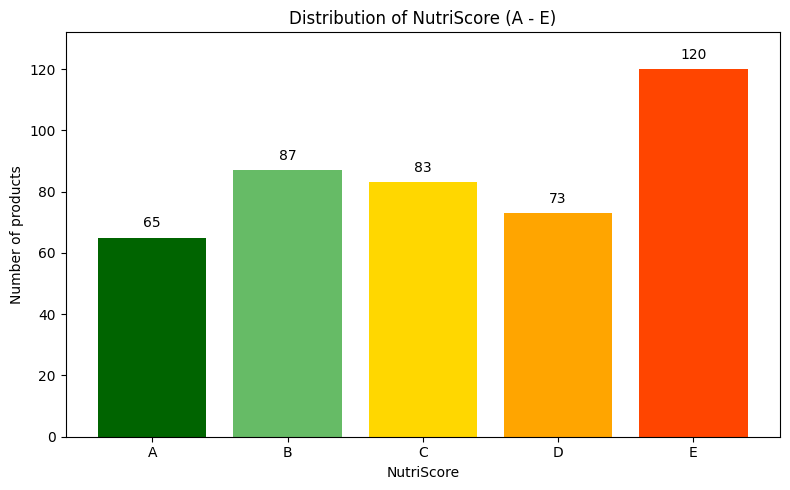

In [16]:
# Histogram of NutriScore A–E with requested colors
# Respective colors: A (dark green), B (light green), C (yellow), D (orange), E (red)
series = df['NutriScore_Lettre'].dropna().astype(str).str.strip().str.upper()
counts = series.value_counts().reindex(['A','B','C','D','E'], fill_value=0)
colors = {
    'A': '#006400',   # dark green
    'B': '#66BB66',   # light green
    'C': '#FFD700',   # yellow
    'D': '#FFA500',   # orange
    'E': '#FF4500'    # red (tomato-like)
}

plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color=[colors[l] for l in counts.index])
plt.title('Distribution of NutriScore (A - E)')
plt.xlabel('NutriScore')
plt.ylabel('Number of products')
plt.ylim(0, counts.values.max() * 1.1 if counts.values.max() > 0 else 1)
# Add values above the bars
for bar, v in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, v + counts.values.max() * 0.02 if counts.values.max() > 0 else v + 0.02, str(int(v)), ha='center', va='bottom')
plt.tight_layout()
# Save in presentation/results/ (already exists)
plt.savefig('presentation/results/nutriscore_hist.png', bbox_inches='tight')
plt.show()

In [17]:
df.to_csv('NutriScore_Dynamic_Dataset_Cleaned.csv', index=False)

In [33]:
def add_column_if_missing(df, colname, values):
    """Ajoute une colonne si elle n'existe pas déjà."""
    if colname not in df.columns:
        df[colname] = values
    else:
        print(f"⚠️ Colonne '{colname}' déjà existante → non modifiée.")
    return df


class ElectreTri:
    def __init__(self, criteria, directions, weights,
                 category_labels=None, lambdas=(0.6, 0.7),
                 preference_thresholds=None):
        """
        criteria: liste des noms de colonnes
        directions: dict crit -> 1 (plus c'est grand mieux) ou -1
        weights: dict crit -> poids
        category_labels: labels des catégories ELECTRE
        lambdas: valeurs de lambda testées
        preference_thresholds: dict crit -> seuil de préférence p
        """
        self.criteria = criteria
        self.directions = directions
        self.weights = self._normalize_weights(weights)
        self.category_labels = category_labels or ["E'", "D'", "C'", "B'", "A'"]
        self.lambdas = lambdas
        self.preference_thresholds = preference_thresholds or {
            c: 0.0 for c in criteria
        }
        self.profiles = None  # sera construit à partir du df

    @staticmethod
    def _normalize_weights(weights):
        total = sum(weights.values())
        return {k: v / total for k, v in weights.items()}

    def _partial_concordance(self, a_val, b_val, crit):
        """C_i(a,b) pour un critère donné."""
        direction = self.directions[crit]
        p = self.preference_thresholds.get(crit, 0.0)

        if direction == 1:
            return 1.0 if a_val + p >= b_val else 0.0
        else:
            return 1.0 if a_val - p <= b_val else 0.0

    def _concordance(self, a, b):
        """Indice de concordance global C(a,b)."""
        c_val = 0.0
        for crit in self.criteria:
            ci = self._partial_concordance(a[crit], b[crit], crit)
            c_val += self.weights[crit] * ci
        return c_val

    def _outranks(self, a, b, lambd):
        """Test a S b (a surclasse b)."""
        return self._concordance(a, b) >= lambd

    def _strictly_preferred(self, a, b, lambd):
        """a ≻ b si a S b et non (b S a)."""
        return self._outranks(a, b, lambd) and not self._outranks(b, a, lambd)

    def build_limiting_profiles(self, df, eps=1e-6):
        """
        Construit les profils pi1..pi6 à partir des quantiles de df.
        """
        profiles_index = [f"pi{k}" for k in range(1, 7)]
        profiles = pd.DataFrame(index=profiles_index, columns=self.criteria, dtype=float)

        for crit in self.criteria:
            col = df[crit].astype(float)
            q20, q40, q60, q80 = col.quantile([0.2, 0.4, 0.6, 0.8])
            cmin, cmax = col.min(), col.max()

            if self.directions[crit] == 1:
                profiles.loc["pi1", crit] = cmin - eps
                profiles.loc["pi2", crit] = q20
                profiles.loc["pi3", crit] = q40
                profiles.loc["pi4", crit] = q60
                profiles.loc["pi5", crit] = q80
                profiles.loc["pi6", crit] = cmax + eps
            else:
                profiles.loc["pi1", crit] = cmax + eps
                profiles.loc["pi2", crit] = q80
                profiles.loc["pi3", crit] = q60
                profiles.loc["pi4", crit] = q40
                profiles.loc["pi5", crit] = q20
                profiles.loc["pi6", crit] = cmin - eps

        self.profiles = profiles
        return profiles

    def _assign_pessimistic_row(self, row, lambd):
        """Affectation pessimiste d’une seule alternative."""
        assigned_cat = self.category_labels[0]  # pire catégorie par défaut
        for k in range(5, 0, -1):
            pi_k = self.profiles.loc[f"pi{k}"]
            if self._outranks(row, pi_k, lambd):
                assigned_cat = self.category_labels[k - 1]
                break
        return assigned_cat

    def _assign_optimistic_row(self, row, lambd):
        """Affectation optimiste d’une seule alternative."""
        assigned_cat = self.category_labels[-1]  # meilleure catégorie par défaut
        for k in range(2, 7):
            pi_k = self.profiles.loc[f"pi{k}"]
            if self._strictly_preferred(pi_k, row, lambd):
                assigned_cat = self.category_labels[k - 2]
                break
        return assigned_cat

    def assign_pessimistic(self, df, lambd):
        return df.apply(lambda row: self._assign_pessimistic_row(row, lambd), axis=1)

    def assign_optimistic(self, df, lambd):
        return df.apply(lambda row: self._assign_optimistic_row(row, lambd), axis=1)

    def apply_and_confusion(self, df, target_col="NutriScore_Lettre"):
        """
        1) Construit les profils
        2) Ajoute les colonnes ELECTRE (pess/opt pour chaque lambda)
        3) Calcule les matrices de confusion
        """
        # 1. Profils
        self.build_limiting_profiles(df)

        confusion_results = {}
        labels_true = ["A", "B", "C", "D", "E"]
        pred_cols = ["A'", "B'", "C'", "D'", "E'"]

        for lambd in self.lambdas:
            # Pessimiste
            colname_pess = f"ELECTRE_Pess_{lambd}"
            pess = self.assign_pessimistic(df, lambd)
            df = add_column_if_missing(df, colname_pess, pess)

            cm_pess = confusion_matrix(
                df[target_col],
                df[colname_pess],
                labels=labels_true
            )
            confusion_results[colname_pess] = pd.DataFrame(
                cm_pess,
                index=[f"NS_{l}" for l in labels_true],
                columns=pred_cols
            )

            # Optimiste
            colname_opt = f"ELECTRE_Opt_{lambd}"
            opt = self.assign_optimistic(df, lambd)
            df = add_column_if_missing(df, colname_opt, opt)

            cm_opt = confusion_matrix(
                df[target_col],
                df[colname_opt],
                labels=labels_true
            )
            confusion_results[colname_opt] = pd.DataFrame(
                cm_opt,
                index=[f"NS_{l}" for l in labels_true],
                columns=pred_cols
            )

        return df, confusion_results

    @staticmethod
    def plot_single_confusion_matrix(name, cm_df):
        """
        Affiche UNE matrice de confusion (ex : RandomForest) dans un plot séparé.
        """
        fig, ax = plt.subplots(figsize=(6, 5))

        im = ax.imshow(cm_df.values, aspect="auto", cmap='Greens')
        ax.set_title(name)
        ax.set_xticks(range(cm_df.shape[1]))
        ax.set_xticklabels(cm_df.columns)
        ax.set_yticks(range(cm_df.shape[0]))
        ax.set_yticklabels(cm_df.index)

        ax.set_xlabel("Prédiction")
        ax.set_ylabel("NutriScore réel")

        # valeurs dans les cases
        for i in range(cm_df.shape[0]):
            for j in range(cm_df.shape[1]):
                ax.text(
                    j, i, int(cm_df.iat[i, j]),
                    ha="center", va="center",
                    color="white" if im.norm(cm_df.iat[i, j]) > 0.5 else "black"
                )

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show()


    @staticmethod
    def plot_confusion_matrices(confusion_results):
        """
        Affiche les matrices de confusion sous forme de heatmaps matplotlib.
        confusion_results: dict nom -> DataFrame
        """
        n = len(confusion_results)
        cols = 2
        rows = int(np.ceil(n / cols))

        # constrained_layout gère automatiquement la place pour la colorbar
        fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows),
                                constrained_layout=True)
        axes = np.array(axes).reshape(-1)

        im = None
        for ax, (name, cm_df) in zip(axes, confusion_results.items()):
            # Use a green colormap for the confusion matrices (Greens)
            im = ax.imshow(cm_df.values, aspect="auto", cmap='Greens')
            ax.set_title(name)
            ax.set_xticks(range(cm_df.shape[1]))
            ax.set_xticklabels(cm_df.columns)
            ax.set_yticks(range(cm_df.shape[0]))
            ax.set_yticklabels(cm_df.index)
            ax.set_xlabel("Catégorie ELECTRE")
            ax.set_ylabel("NutriScore réel")

            # valeurs dans les cases
            for i in range(cm_df.shape[0]):
                for j in range(cm_df.shape[1]):
                    ax.text(j, i, int(cm_df.iat[i, j]),
                            ha="center", va="center")

        # supprimer les axes en trop s'il y en a
        for ax in axes[n:]:
            ax.remove()

        # colorbar commune à tous les axes, avec un peu d'espace (pad)
        fig.colorbar(im, ax=axes[:n], fraction=0.046, pad=0.04)

        plt.savefig('presentation/results/confusion_matrix.png', bbox_inches='tight')
        plt.show()

 




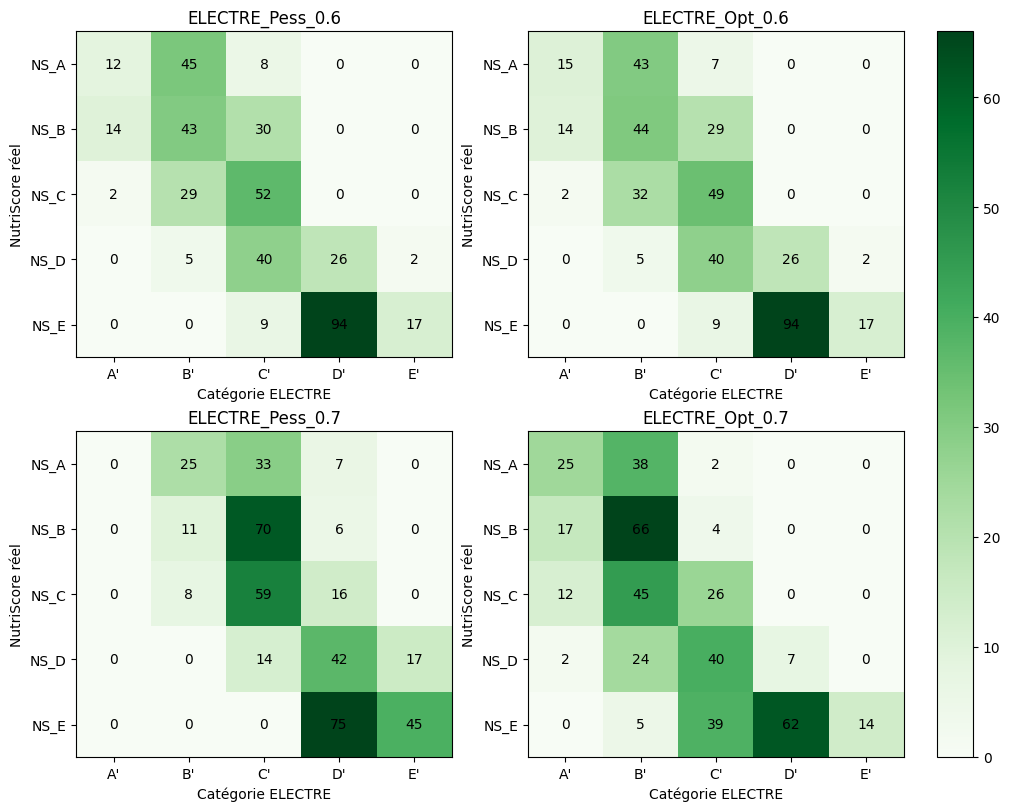

In [19]:
criteria = [
    "Energie_kJ", "Sucres_g", "Graisses_Sat_g", "Sel_g",
    "Proteines_g", "Fibres_g", "Fruits_Legumes_Pct", "GreenScore_Score"
]

directions = {
    "Energie_kJ": -1,
    "Sucres_g": -1,
    "Graisses_Sat_g": -1,
    "Sel_g": -1,
    "Proteines_g": 1,
    "Fibres_g": 1,
    "Fruits_Legumes_Pct": 1,
    "GreenScore_Score": 1
}

weights = {c: 1 / len(criteria) for c in criteria}
category_labels = ["E", "D", "C", "B", "A"]

model = ElectreTri(
    criteria=criteria,
    directions=directions,
    weights=weights,
    category_labels=category_labels,
    lambdas=(0.6, 0.7)
)

df, confusions = model.apply_and_confusion(df, target_col="NutriScore_Lettre")

# Affichage graphique des matrices de confusion
ElectreTri.plot_confusion_matrices(confusions)


In [20]:
df.head()

,Nom_Produit,Marque,Categorie,Energie_kJ,Sucres_g,Graisses_Sat_g,Sel_g,Proteines_g,Fibres_g,Fruits_Legumes_Pct,NutriScore_Score,NutriScore_Lettre,Points_N,Points_P,GreenScore_Lettre,GreenScore_Score,ELECTRE_Pess_0.6,ELECTRE_Opt_0.6,ELECTRE_Pess_0.7,ELECTRE_Opt_0.7
0,Concentré de tomates Aicha,Aicha,vegetables,132.0,2.43,0.0,0.270,1.24,0.811,0.0,1,B,1,0,C,59,C,C,C,B
1,Aicha Tomato Paste,Aicha,vegetables,496.0,9.00,0.0,0.500,4.60,3.000,0.0,3,C,4,1,C,46,C,C,C,B
2,Raw kimchi,Vadasz,vegetables,63.0,0.00,0.1,2.065,1.10,1.800,0.0,10,C,10,0,A,88,A,A,B,A
3,Beurre de cacahuètes,Maribel,vegetables,2860.0,3.90,12.0,0.030,30.40,9.200,0.0,14,D,19,5,D,34,C,C,D,B
4,Carottes rapees citron dnp 320g,Bonduelle,vegetables,301.0,4.50,0.3,0.710,1.00,3.000,86.0,-1,A,4,5,A,79,B,B,C,B


Saved presentation/results/electre_trihist_combined.png


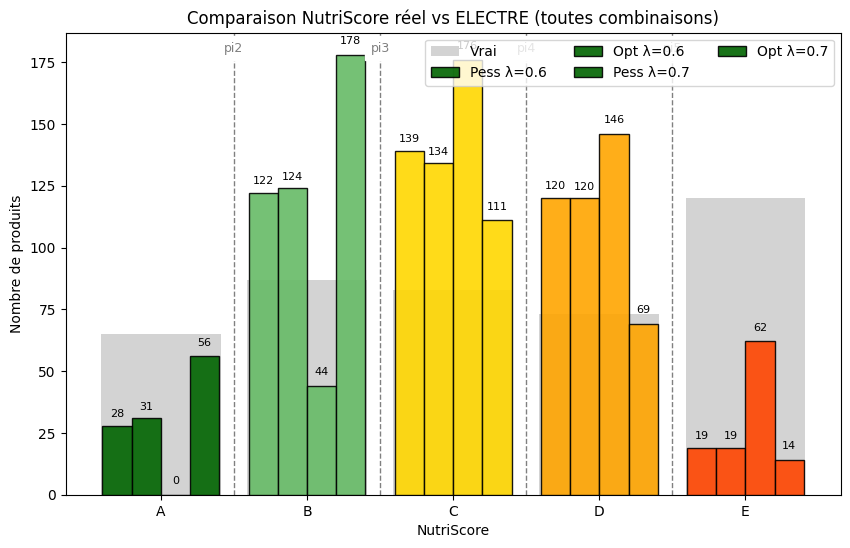

In [21]:
# Visualisation combinée (Overlay) : tout dans une seule figure
def plot_electre_combined(df, model, target_col='NutriScore_Lettre', save=True):
    labels = ['A','B','C','D','E']
    colors = {
        'A': '#006400',  # dark green
        'B': '#66BB66',  # light green
        'C': '#FFD700',  # yellow
        'D': '#FFA500',  # orange
        'E': '#FF4500'   # red
    }
    modes = ['Pess', 'Opt']

    # True counts (background)
    true_series = df[target_col].dropna().astype(str).str.strip().str.upper()
    counts_true = true_series.value_counts().reindex(labels, fill_value=0)

    combos = [(mode, lambd) for lambd in model.lambdas for mode in modes]
    n_combos = len(combos)

    total_width = 0.8
    width = total_width / max(1, n_combos)
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, counts_true.values, width=total_width + 0.02, color='lightgray', label='Vrai', zorder=0)

    for k, (mode, lambd) in enumerate(combos):
        colname = f'ELECTRE_{mode}_{lambd}'
        if colname not in df.columns:
            assigned = model.assign_pessimistic(df, lambd) if mode == 'Pess' else model.assign_optimistic(df, lambd)
            df[colname] = assigned

        assigned_series = df[colname].dropna().astype(str).str.strip().str.upper()
        counts_assigned = assigned_series.value_counts().reindex(labels, fill_value=0)

        offset = (k - (n_combos - 1) / 2) * width
        bars = ax.bar(x + offset, counts_assigned.values, width, color=[colors[l] for l in labels],
                      label=f'{mode} λ={lambd}', zorder=3, edgecolor='k', alpha=0.9)

        max_val = max(counts_true.max(), counts_assigned.max(), 1)
        for bar, v in zip(bars, counts_assigned.values):
            ax.text(bar.get_x() + bar.get_width() / 2, v + max_val * 0.02, int(v), ha='center', va='bottom', fontsize=8)

    # boundary markers between categories
    boundary_positions = [i + 0.5 for i in range(len(labels) - 1)]
    for idx_b, pos in enumerate(boundary_positions, start=2):
        ax.axvline(pos, color='gray', linestyle='--', linewidth=1)
        ax.text(pos, ax.get_ylim()[1] * 0.98, f'pi{idx_b}', ha='center', va='top', color='gray', fontsize=9, backgroundcolor='white')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('NutriScore')
    ax.set_ylabel('Nombre de produits')
    ax.set_title('Comparaison NutriScore réel vs ELECTRE (toutes combinaisons)')
    ax.legend(ncol=min(3, max(1, n_combos)))

    if save:
        fname = 'presentation/results/electre_trihist_combined.png'
        plt.savefig(fname, bbox_inches='tight')
        print(f"Saved {fname}")
    plt.show()

# Appel à la fonction pour exécution
plot_electre_combined(df, model, target_col='NutriScore_Lettre', save=True)

In [35]:
class RandomForestNutri:
    def __init__(self, criteria, target_col="NutriScore_Lettre",
                 n_estimators=200, random_state=42, max_depth=None):
        """
        RandomForest pour prédire le NutriScore à partir des critères nutritionnels.
        """
        self.criteria = criteria
        self.target_col = target_col
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            random_state=random_state,
            max_depth=max_depth
        )

    def add_predictions_and_confusion(self, df, n_train=50):
        """
        - Sépare le dataset en :
            * train : n_train lignes (stratifié par NutriScore)
            * test  : le reste
        - Entraîne la RF sur le train
        - Prédit sur le test
        - Ajoute une colonne 'RF_Pred' (remplie seulement pour les lignes de test)
        - Retourne :
            * df mis à jour
            * matrice de confusion (test uniquement)
        """
        X = df[self.criteria]
        y = df[self.target_col]
        idx = df.index

        # Si 50 > nb de lignes - 1, on réduit un peu pour éviter les erreurs
        n_train = min(n_train, len(df) - 1)

        X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
            X, y, idx,
            train_size=n_train,
            stratify=y,         # assure une répartition équilibrée des classes
            random_state=42
        )

        # Entraînement
        self.model.fit(X_train, y_train)

        # Prédiction sur le test uniquement
        y_pred = self.model.predict(X_test)

        # Colonne de prédiction (NaN partout sauf sur le test)
        df = add_column_if_missing(df, "RF_Pred", np.nan)
        df.loc[idx_test, "RF_Pred"] = y_pred

        # Matrice de confusion sur le test
        labels_true = ["A", "B", "C", "D", "E"]
        cm = confusion_matrix(y_test, y_pred, labels=labels_true)
        cm_df = pd.DataFrame(
            cm,
            index=[f"NS_{l}" for l in labels_true],
            columns=labels_true
        )
        return df, cm_df

    @staticmethod
    def plot_rf_feature_dendrogram(df, criteria, save_path=None):
        """
        Dendrogramme hiérarchique des critères utilisés par la Random Forest.
        On regroupe les features en fonction de la corrélation absolue entre elles.
        """
        # Corrélation absolue entre critères
        corr = df[criteria].corr().abs()

        # Distance = 1 - corrélation
        dist = 1 - corr
        # La fonction linkage attend un vecteur condensé de distances
        dist_condensed = squareform(dist.values, checks=False)

        # Clustering hiérarchique (méthode 'average' = UPGMA)
        Z = linkage(dist_condensed, method='average')

        # Plot
        plt.figure(figsize=(10, 5))
        dendrogram(
            Z,
            labels=criteria,
            leaf_rotation=0,
            leaf_font_size=10,
        )
        plt.title("Dendrogramme des critères (Random Forest)")
        plt.ylabel("Distance (1 - |corrélation|)")
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Dendrogramme sauvegardé dans : {save_path}")

        plt.show()

    @staticmethod
    def plot_sample_dendrogram_with_nutriscore(df, criteria, target_col="NutriScore_Lettre",
                                            max_samples=200):
        """
        Dendrogramme hiérarchique des PRODUITS, labels = NutriScore (A/B/C/D/E).

        - On clusterise les lignes de df en fonction des critères nutritionnels.
        - Chaque feuille est un produit, étiqueté par sa lettre de NutriScore.
        - Les lettres sont colorées par classe.
        """
        # Option : pour éviter un graphe illisible si trop de produits
        if len(df) > max_samples:
            df = df.sample(max_samples, random_state=42)

        X = df[criteria].values
        y = df[target_col].values

        # Standardisation pour que tous les critères soient à la même échelle
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Clustering hiérarchique des produits
        # (Ward sur distance euclidienne)
        Z = linkage(X_scaled, method="ward")

        # Mapping couleur pour les classes A..E
        color_map = {
            "A": "green",
            "B": "limegreen",
            "C": "orange",
            "D": "red",
            "E": "darkred"
        }

        plt.figure(figsize=(10, 5))
        dendrogram(
            Z,
            labels=y,              # A/B/C/D/E en labels de feuilles
            leaf_rotation=90,
            leaf_font_size=8,
        )

        ax = plt.gca()

        # Colorer chaque label selon sa classe
        for tick in ax.get_xmajorticklabels():
            grade = tick.get_text()
            tick.set_color(color_map.get(grade, "black"))

        plt.title("Dendrogramme des produits annoté par NutriScore")
        plt.ylabel("Distance (similarité entre produits)")
        plt.tight_layout()

        # Légende des couleurs
        handles = [
            mpatches.Patch(color=c, label=cl)
            for cl, c in color_map.items()
        ]
        plt.legend(handles=handles, title="NutriScore", loc="upper right")

        plt.show()

C:\Users\Samue\AppData\Local\Temp\ipykernel_7312\904694606.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['B' 'D' 'D' 'E' 'C' 'C' 'E' 'E' 'B' 'B' 'A' 'B' 'C' 'E' 'C' 'C' 'E' 'B'
 'E' 'B' 'B' 'B' 'C' 'E' 'B' 'B' 'E' 'D' 'E' 'E' 'C' 'D' 'A' 'C' 'B' 'C'
 'C' 'E' 'C' 'E' 'C' 'B' 'E' 'A' 'C' 'C' 'B' 'C' 'E' 'E' 'E' 'B' 'C' 'C'
 'A' 'C' 'A' 'D' 'D' 'E' 'B' 'E' 'E' 'B' 'E' 'B' 'B' 'E' 'B' 'E' 'C' 'A'
 'C' 'E' 'E' 'C' 'A' 'B' 'E' 'B' 'B' 'C' 'C' 'D' 'B' 'E' 'B' 'E' 'E' 'B'
 'B' 'B' 'E' 'E' 'C' 'E' 'B' 'B' 'E' 'B' 'B' 'C' 'E' 'E' 'B' 'E' 'A' 'E'
 'B' 'B' 'C' 'A' 'E' 'E' 'E' 'D' 'B' 'C' 'B' 'E' 'E' 'B' 'B' 'E' 'E' 'C'
 'C' 'A' 'C' 'B' 'E' 'D' 'B' 'C' 'C' 'C' 'A' 'C' 'B' 'A' 'E' 'E' 'E' 'B'
 'E' 'E' 'B' 'E' 'C' 'D' 'E' 'B' 'D' 'E' 'B' 'E' 'E' 'B' 'C' 'E' 'C' 'B'
 'D' 'D' 'D' 'E' 'D' 'C' 'E' 'B' 'E' 'B' 'E' 'E' 'E' 'E' 'C' 'E' 'A' 'C'
 'E' 'E' 'C' 'A' 'C' 'E' 'D' 'C' 'A' 'E' 'E' 'A' 'B' 'A' 'A' 'E' 'B' 'E'
 '

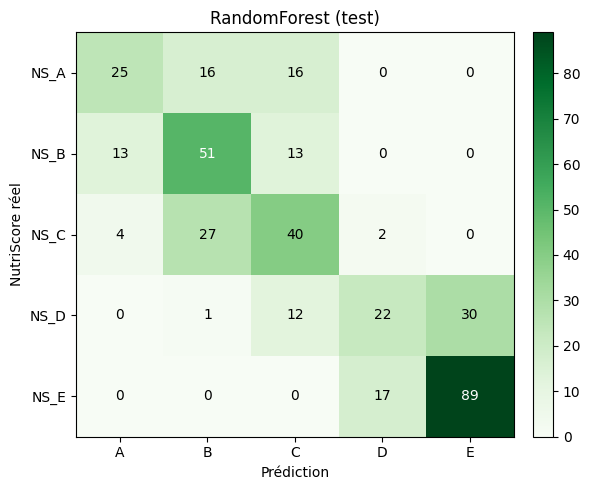

In [23]:
rf_model = RandomForestNutri(criteria=criteria,
                             target_col="NutriScore_Lettre")

df, rf_cm = rf_model.add_predictions_and_confusion(df, n_train=50)

ElectreTri.plot_single_confusion_matrix("RandomForest (test)", rf_cm)

df.to_csv('NutriScore_Dynamic_Dataset_ELECTRE_RF.csv', index=False)

Dendrogramme sauvegardé dans : presentation/results/random_forest_dendrogram.png


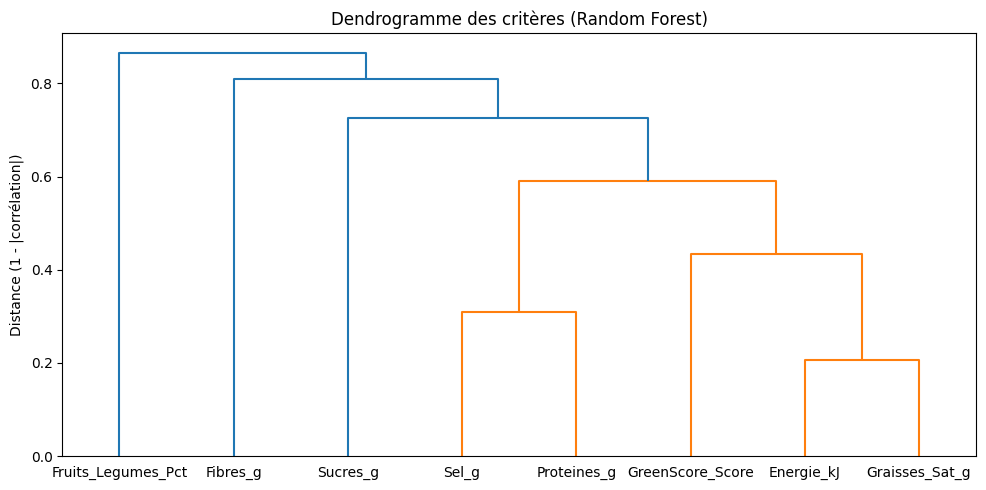

In [30]:
# Dendrogramme des PRODUITS (celui qui montre les classes)
RandomForestNutri.plot_rf_feature_dendrogram(
    df,
    criteria,
    save_path="presentation/results/random_forest_dendrogram.png"
)



In [43]:
class WeightedSumModel:
    def __init__(self, criteria, directions, weights, target_col="NutriScore_Lettre"):
        """
        Weighted Sum Model (WSM)
        - criteria : liste des critères
        - directions : dict crit -> 1 (plus c'est grand mieux) ou -1 (plus c'est petit mieux)
        - weights : dict crit -> poids (ils seront normalisés automatiquement)
        """
        self.criteria = criteria
        self.directions = directions
        self.weights = self._normalize(weights)
        self.target_col = target_col

    def _normalize(self, w):
        s = sum(w.values())
        return {k: v / s for k, v in w.items()}

    def compute_score(self, row):
        """Score = somme des poids * valeur du critère (normalisé)."""
        s = 0
        for c in self.criteria:
            s += self.weights[c] * row[c]
        return s

    def score_dataset(self, df):
        """Calcule les scores WSM pour tout le dataset avec normalisation Min-Max."""
        # On travaille sur une copie pour ne pas modifier les données brutes
        df_norm = df.copy()
        
        for c in self.criteria:
            col = df[c].astype(float)
            c_min = col.min()
            c_max = col.max()
            
            if c_max == c_min:
                df_norm[c] = 0
                continue
                
            # Normalisation pour obtenir un score de "coût" (0 = meilleur, 1 = pire)
            # Si direction = -1 (mauvais, ex: sucre), on veut que beaucoup de sucre => score élevé (mauvais)
            # Donc on normalise : (x - min) / (max - min) -> 1 si max
            if self.directions[c] == -1:
                df_norm[c] = (col - c_min) / (c_max - c_min)
            
            # Si direction = 1 (bon, ex: fibres), on veut que beaucoup de fibres => score faible (bon)
            # Donc on inverse : (max - x) / (max - min) -> 0 si max
            else:
                df_norm[c] = (c_max - col) / (c_max - c_min)

        # Calcul du score sur les données normalisées
        scores = df_norm.apply(self.compute_score, axis=1)
        
        # Etirement (Stretching) du score final pour couvrir l'intervalle [0, 1]
        # Cela permet d'atteindre les extrêmes A (0) et E (1)
        s_min = scores.min()
        s_max = scores.max()
        if s_max > s_min:
            scores = (scores - s_min) / (s_max - s_min)

        df["WSM_Score"] = scores
        return df

    def categorize(self, df, thresholds=None):
        """
        Convertit le score WSM en NutriScore A/B/C/D/E selon des seuils.
        
        - thresholds = dict indiquant les coupures
            Ex: {"A": 0.2, "B": 0.4, "C": 0.6, "D": 0.8}
        """
        if thresholds is None:
            # seuils génériques pour un score entre 0 et 1
            thresholds = {"A": 0.2, "B": 0.4, "C": 0.6, "D": 0.8}

        cats = []
        for s in df["WSM_Score"]:
            if s <= thresholds["A"]:
                cats.append("A")
            elif s <= thresholds["B"]:
                cats.append("B")
            elif s <= thresholds["C"]:
                cats.append("C")
            elif s <= thresholds["D"]:
                cats.append("D")
            else:
                cats.append("E")

        df["WSM_Pred"] = cats
        return df

    def confusion(self, df):
        """Retourne la matrice de confusion WSM vs NutriScore réel."""
        labels = ["A", "B", "C", "D", "E"]
        cm = confusion_matrix(df[self.target_col], df["WSM_Pred"], labels=labels)
        cm_df = pd.DataFrame(
            cm,
            index=[f"NS_{l}" for l in labels],
            columns=labels
        )
        return cm_df

    def export_configuration(self, filepath=None):
        """
        Exporte la configuration du modèle (Critères, Directions, Poids).
        Retourne un DataFrame. Si filepath est fourni, sauvegarde en CSV.
        """
        rows = []
        for c in self.criteria:
            rows.append({
                "Criterion": c,
                "Direction": self.directions.get(c),
                "Weight": self.weights.get(c)
            })
        df_config = pd.DataFrame(rows)
        if filepath:
            df_config.to_csv(filepath, index=False)
            print(f"Configuration exportée dans {filepath}")
        return df_config

Configuration exportée dans presentation/results/wsm_configuration.csv


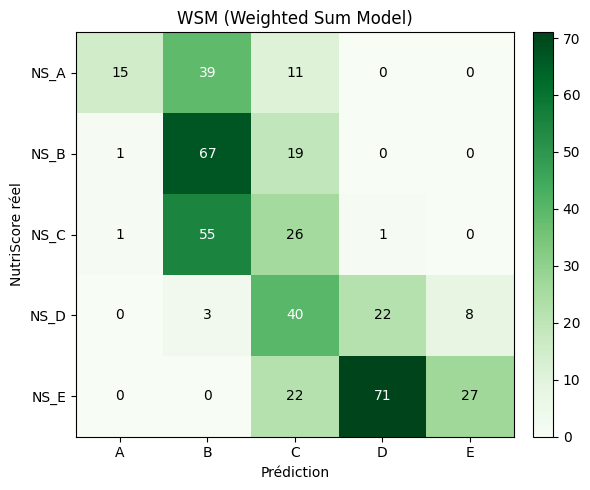

In [44]:
weights = {c: 1 for c in criteria}

wsm = WeightedSumModel(criteria, directions, weights, target_col="NutriScore_Lettre")

df = wsm.score_dataset(df)
df = wsm.categorize(df)   # convertit en A/B/C/D/E
cm_wsm = wsm.confusion(df)

# Export des paramètres du modèle
wsm.export_configuration("presentation/results/wsm_configuration.csv")

ElectreTri.plot_single_confusion_matrix("WSM (Weighted Sum Model)", cm_wsm)